In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
import gc
import numpy as np

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train/255.0
x_test = x_test/255.0

170498071/170498071 [==============================] - 13s 0us/step


In [3]:
x_train.shape

(50000, 32, 32, 3)

In [4]:
# encoder
input = layers.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
encoded_latent = layers.Flatten()(x)

encoder = Model(input, encoded_latent)
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          18496 

In [5]:
# decoder
d = layers.Reshape((4, 4, 64*4))(encoded_latent)
d = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(d)
d = layers.BatchNormalization()(d)
d = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(d)
d = layers.BatchNormalization()(d)
d = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(d)
decoder_output = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(d)

autoencoder = Model(input, decoder_output)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          1849

In [6]:
history=autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
391/391 [==============================] - 28s 17ms/step - loss: 0.5884 - val_loss: 0.6304
Epoch 2/50
391/391 [==============================] - 5s 13ms/step - loss: 0.5713 - val_loss: 0.5710
Epoch 3/50
391/391 [==============================] - 5s 13ms/step - loss: 0.5682 - val_loss: 0.5680
Epoch 4/50
391/391 [==============================] - 5s 13ms/step - loss: 0.5666 - val_loss: 0.5665
Epoch 5/50
391/391 [==============================] - 5s 13ms/step - loss: 0.5655 - val_loss: 0.5659
Epoch 6/50
391/391 [==============================] - 5s 13ms/step - loss: 0.5646 - val_loss: 0.5652
Epoch 7/50
391/391 [==============================] - 5s 13ms/step - loss: 0.5639 - val_loss: 0.5647
Epoch 8/50
391/391 [==============================] - 5s 13ms/step - loss: 0.5635 - val_loss: 0.5640
Epoch 9/50
391/391 [==============================] - 5s 13ms/step - loss: 0.5631 - val_loss: 0.5638
Epoch 10/50
391/391 [==============================] - 5s 13ms/step - loss: 0.5627 - val_l

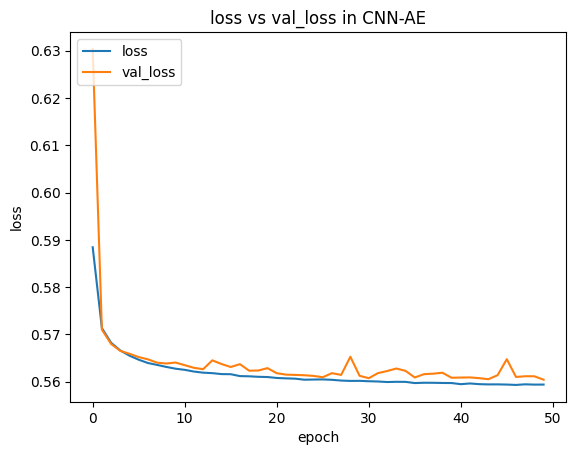

In [7]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss vs val_loss in CNN-AE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

In [8]:
### classification#
encoder_featutres = encoder.predict(x_train)

1563/1563 [==============================] - 3s 2ms/step


In [9]:
encoder_featutres.shape

(50000, 4096)

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

forest_clf = RandomForestClassifier(max_depth=20, random_state=0)
forest_clf.fit(encoder_featutres, y_train)

<ipython-input-10-e345966f80cd>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest_clf.fit(encoder_featutres, y_train)


RandomForestClassifier(max_depth=20, random_state=0)

In [11]:
encoder_featrues_test = encoder.predict(x_test)
y_pred = forest_clf.predict(encoder_featrues_test)
accuracy_score(y_test, y_pred)  # classification accuracy

313/313 [==============================] - 1s 2ms/step


0.4779

In [12]:
y_pred.shape

(10000,)

In [13]:
reconstructed_test = autoencoder.predict(x_test)

313/313 [==============================] - 1s 3ms/step


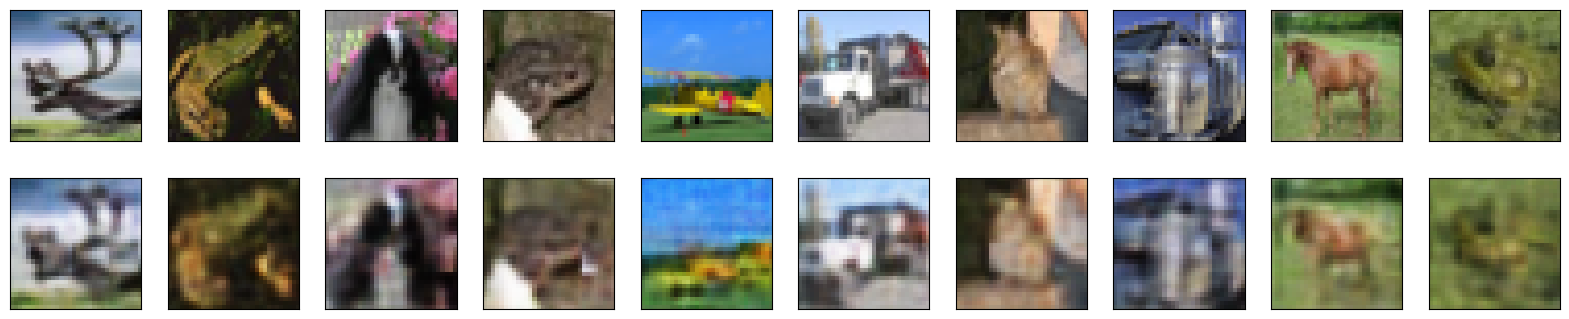

In [14]:
plt.figure(figsize=(20, 4))
for i in range(10):
        ax = plt.subplot(2, 10, i + 1)
        plt.imshow(x_test[i+40])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, 10, i + 1 + 10)
        plt.imshow(reconstructed_test[i+40])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()

In [15]:
## add noise
def add_noise(x_train,x_test,noise_factor = 0.5):
  x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
  x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
  x_train_noisy = np.clip(x_train_noisy, 0.0, 1.0)
  x_test_noisy = np.clip(x_test_noisy, 0.0, 1.0)
  return x_train_noisy,x_test_noisy

In [16]:
x_train_noisy,x_test_noisy =add_noise(x_train,x_test)

In [17]:
# train denoisong ae
history_denoising=autoencoder.fit(x_train_noisy, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/50
391/391 [==============================] - 6s 15ms/step - loss: 0.5809 - val_loss: 0.5809
Epoch 2/50
391/391 [==============================] - 5s 13ms/step - loss: 0.5792 - val_loss: 0.5802
Epoch 3/50
391/391 [==============================] - 5s 13ms/step - loss: 0.5786 - val_loss: 0.5807
Epoch 4/50
391/391 [==============================] - 5s 12ms/step - loss: 0.5785 - val_loss: 0.5793
Epoch 5/50
391/391 [==============================] - 5s 13ms/step - loss: 0.5782 - val_loss: 0.5817
Epoch 6/50
391/391 [==============================] - 5s 12ms/step - loss: 0.5782 - val_loss: 0.5789
Epoch 7/50
391/391 [==============================] - 5s 12ms/step - loss: 0.5780 - val_loss: 0.5789
Epoch 8/50
391/391 [==============================] - 5s 14ms/step - loss: 0.5779 - val_loss: 0.5801
Epoch 9/50
391/391 [==============================] - 5s 12ms/step - loss: 0.5779 - val_loss: 0.5789
Epoch 10/50
391/391 [==============================] - 5s 13ms/step - loss: 0.5778 - val_lo

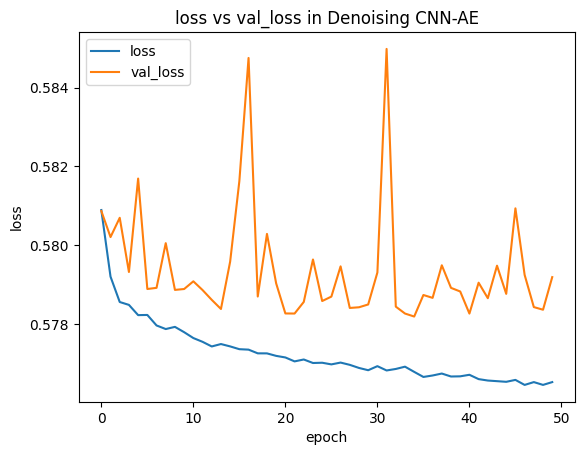

In [18]:
from matplotlib import pyplot as plt
plt.plot(history_denoising.history['loss'])
plt.plot(history_denoising.history['val_loss'])
plt.title('loss vs val_loss in Denoising CNN-AE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

In [19]:
denoising_encoder_featutres = encoder.predict(x_train)

1563/1563 [==============================] - 2s 2ms/step


In [20]:
denoising_encoder_featutres.shape

(50000, 4096)

In [21]:
denoising_forest_clf = RandomForestClassifier(max_depth=20, random_state=0)
denoising_forest_clf.fit(denoising_encoder_featutres, y_train)

<ipython-input-21-9acd9163b27a>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  denoising_forest_clf.fit(denoising_encoder_featutres, y_train)


RandomForestClassifier(max_depth=20, random_state=0)

In [22]:
denoising_encoder_featrues_test = encoder.predict(x_test)
y_pred = denoising_forest_clf.predict(denoising_encoder_featrues_test)
accuracy_score(y_test, y_pred)  # classification accuracy in denoising vbersion

313/313 [==============================] - 1s 2ms/step


0.4983